In [2]:
%pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/wj/pm_4pvr93gl31slydyn19nzr0000gn/T/pip-req-build-dzneo99m
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /private/var/folders/wj/pm_4pvr93gl31slydyn19nzr0000gn/T/pip-req-build-dzneo99m
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [7]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if display_list[i].shape[2]>1:
            plt.imshow(display_list[i])
        else:
            plt.imshow(np.array(display_list[i]).reshape(128,128))
        plt.axis('off')
    plt.show()

2024-07-22 03:02:54.813517: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


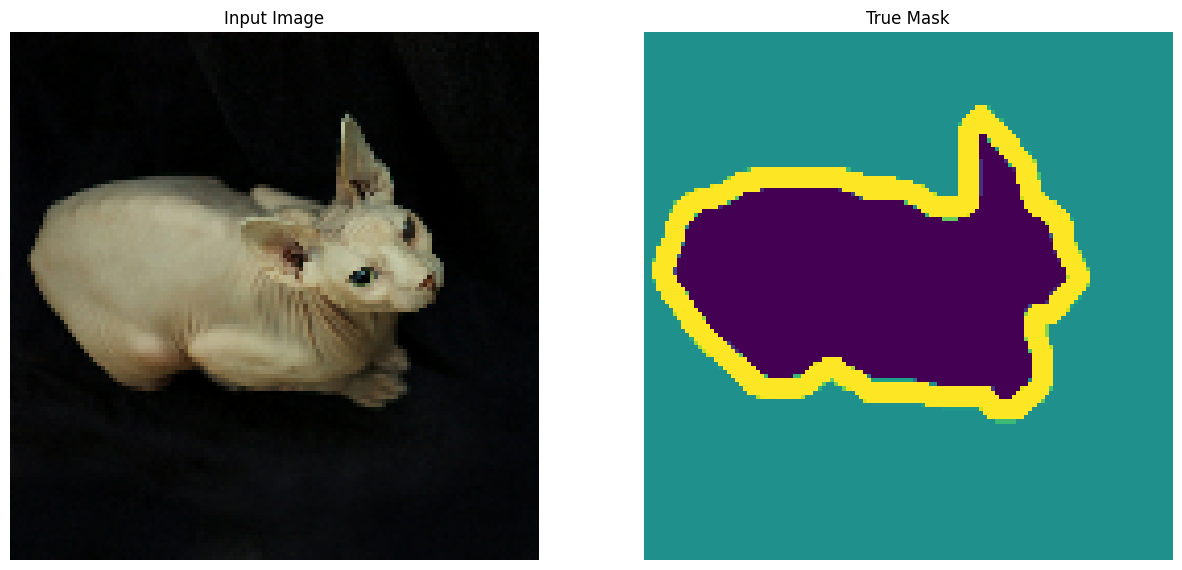

In [13]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [14]:
OUTPUT_CHANNELS = 3

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 다음과 같은 레이어 활성화 함수를 사용합니다.
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 피쳐를 추출하는 모델을 생성합니다.
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [16]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [17]:
def unet_model(output_channels):

    # 모델의 마지막 레이어입니다.
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # 모델을 통해 다운샘플링합니다.
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # 업샘플링과 스킵 커넥션(skip conection)을 합니다.
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

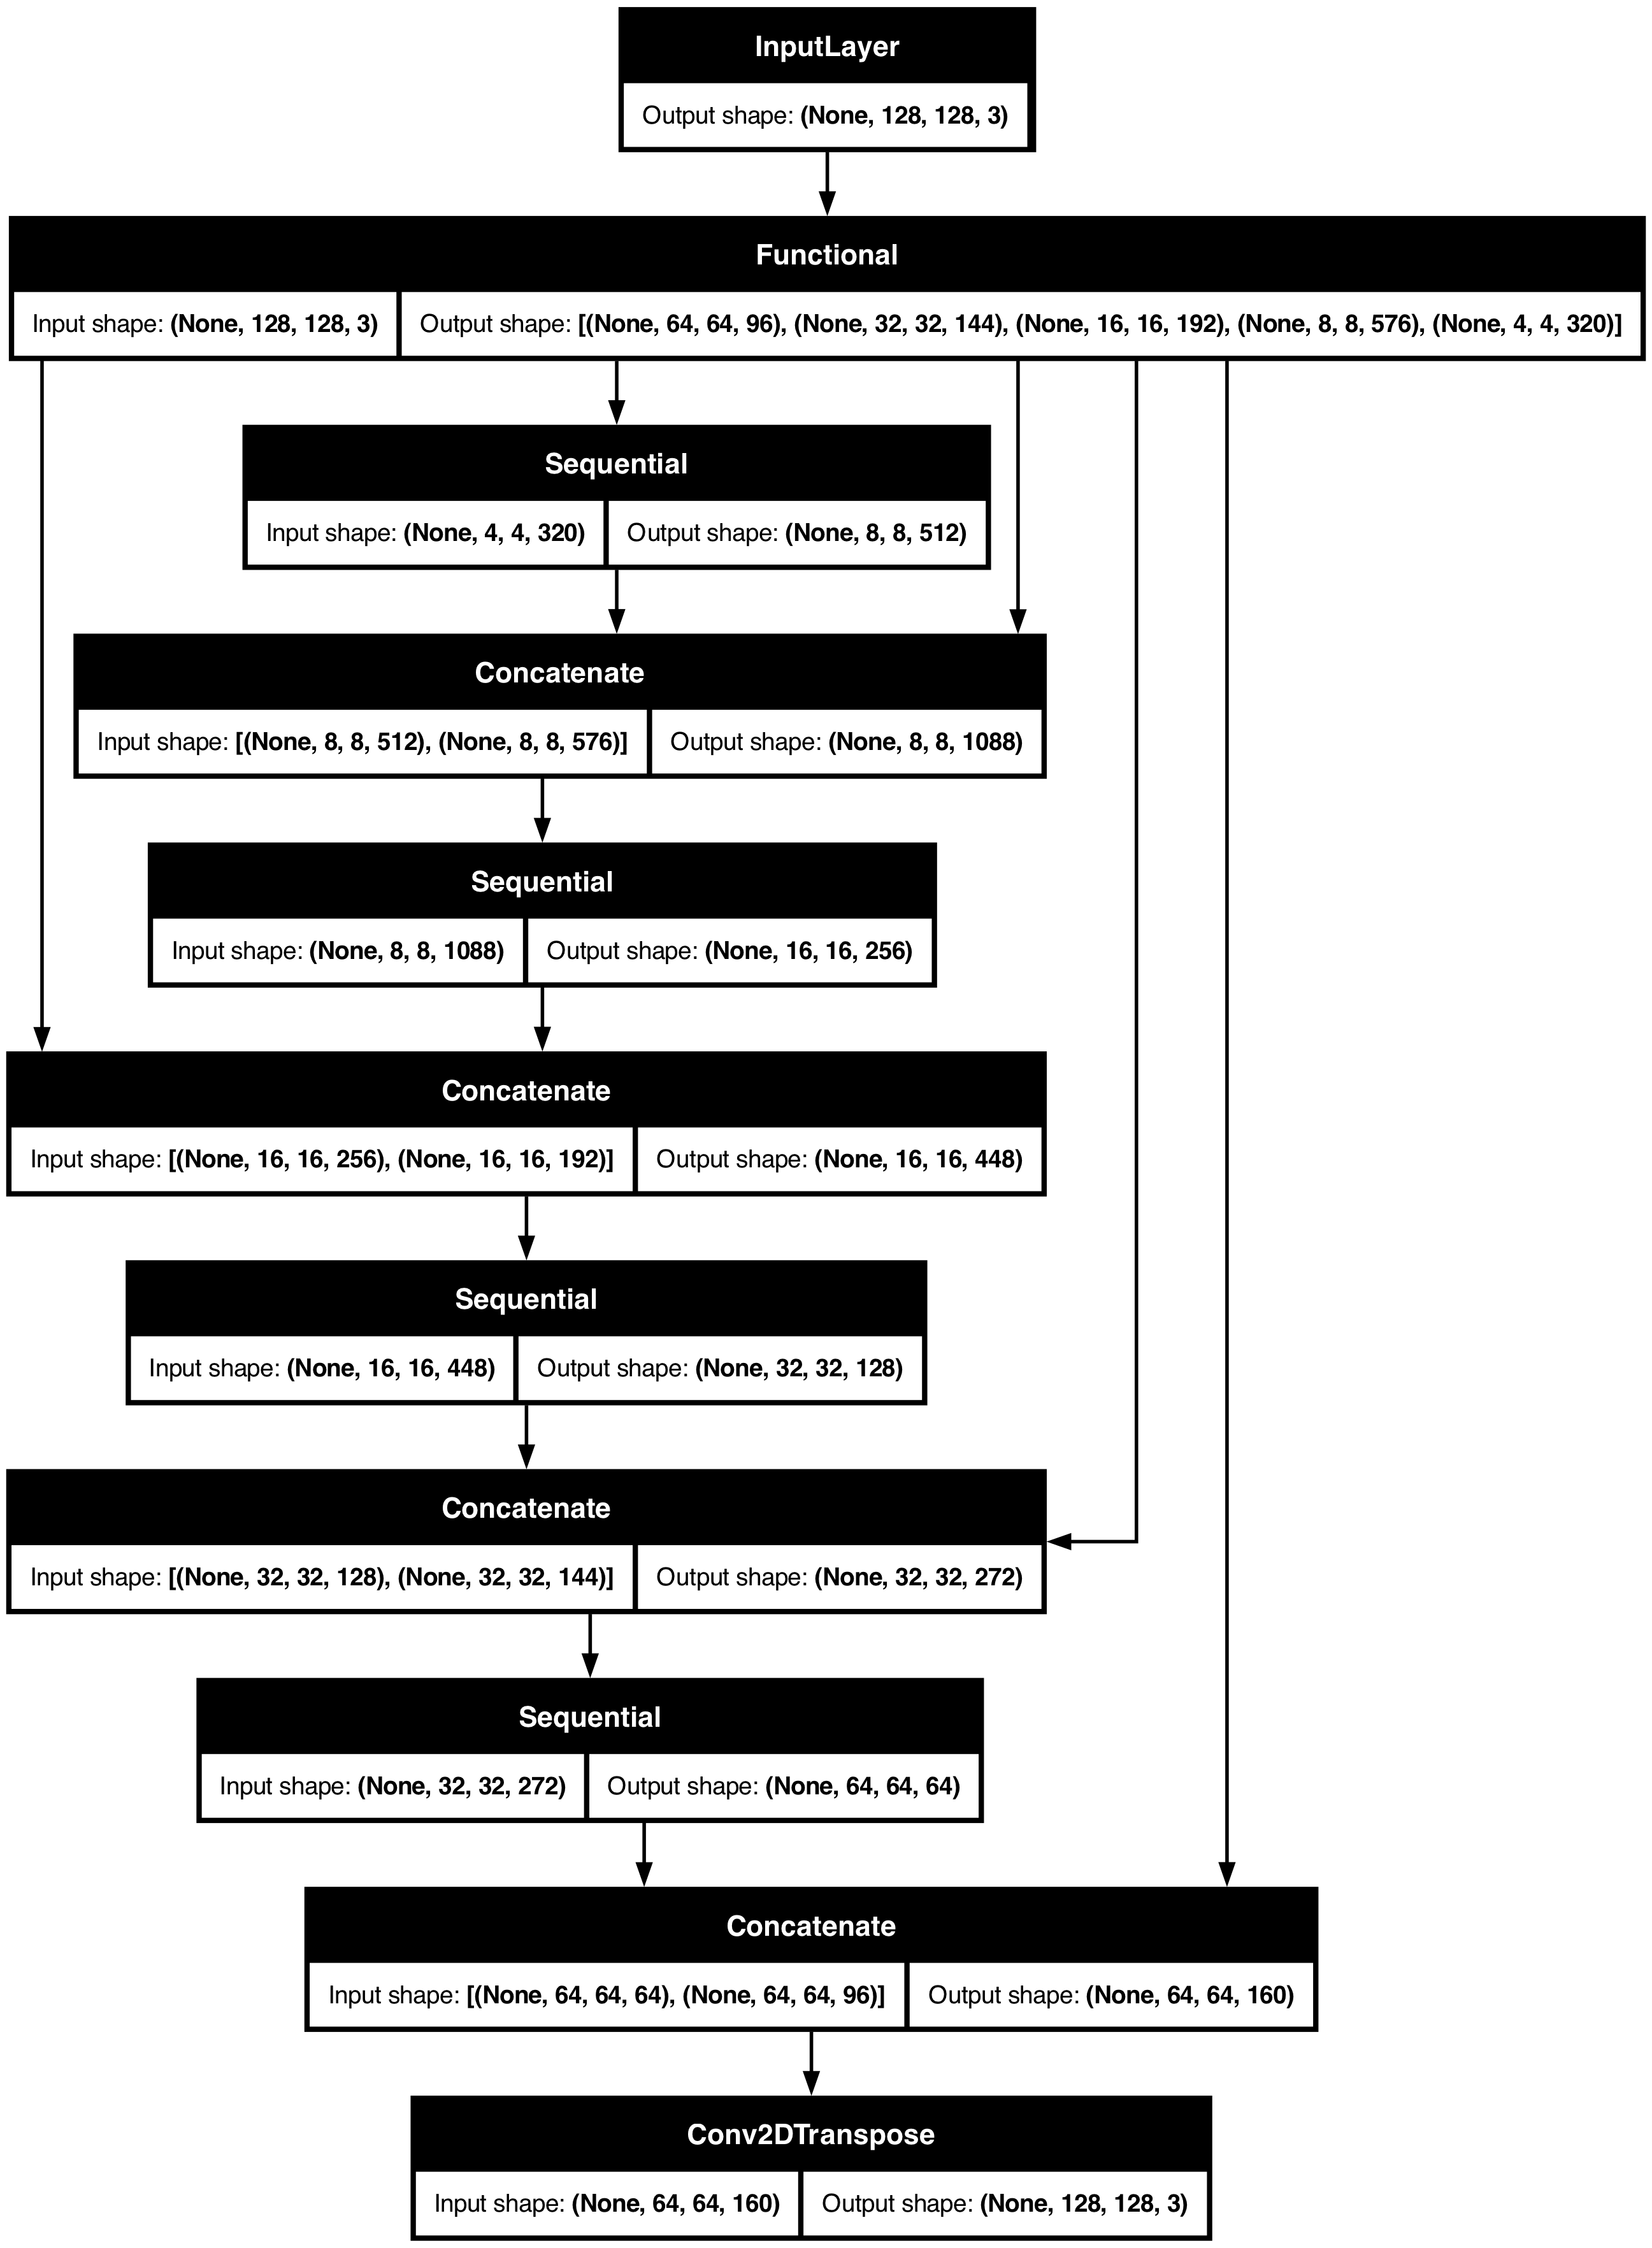

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [24]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [25]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


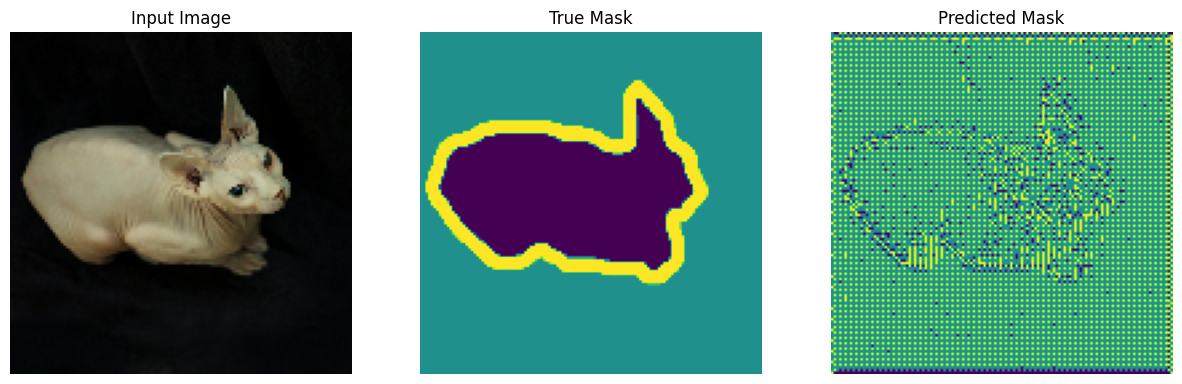

In [26]:
show_predictions()


In [27]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


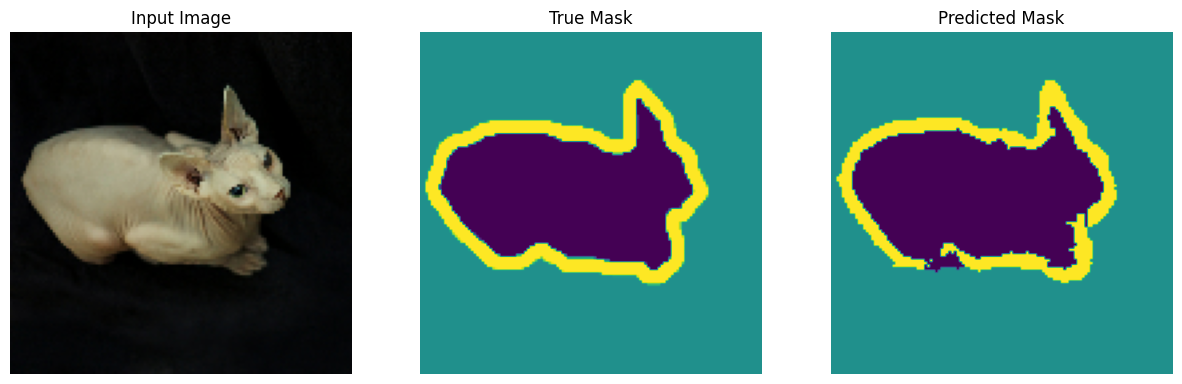


Sample Prediction after epoch 10

57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 775ms/step - accuracy: 0.9074 - loss: 0.2142 - val_accuracy: 0.8883 - val_loss: 0.2892


In [28]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

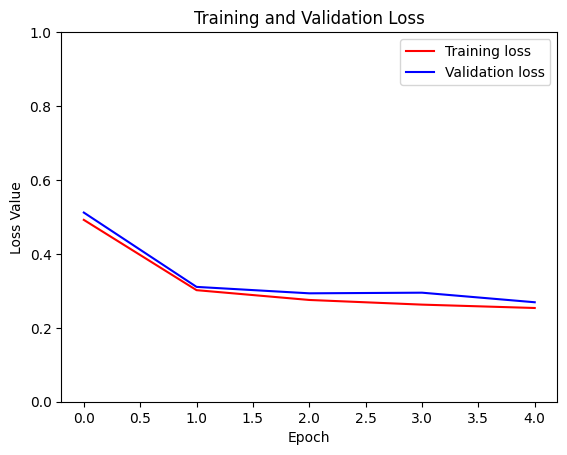

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss', color = 'b')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


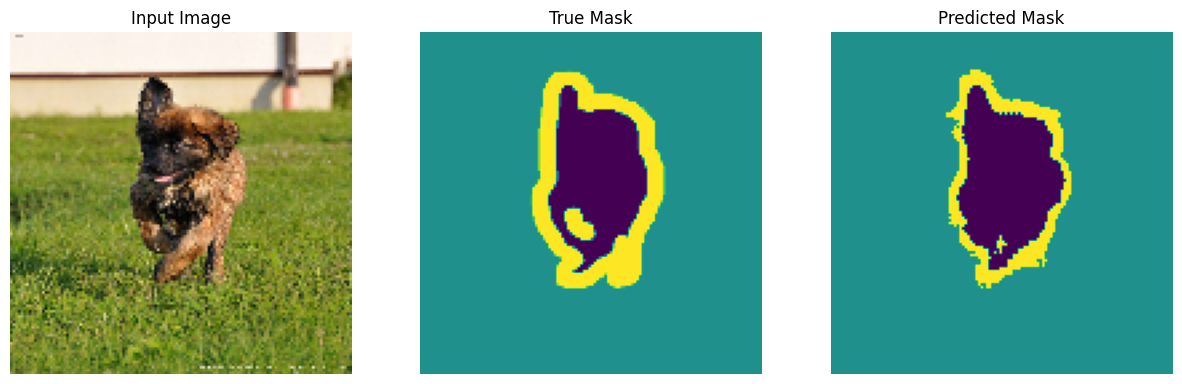

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


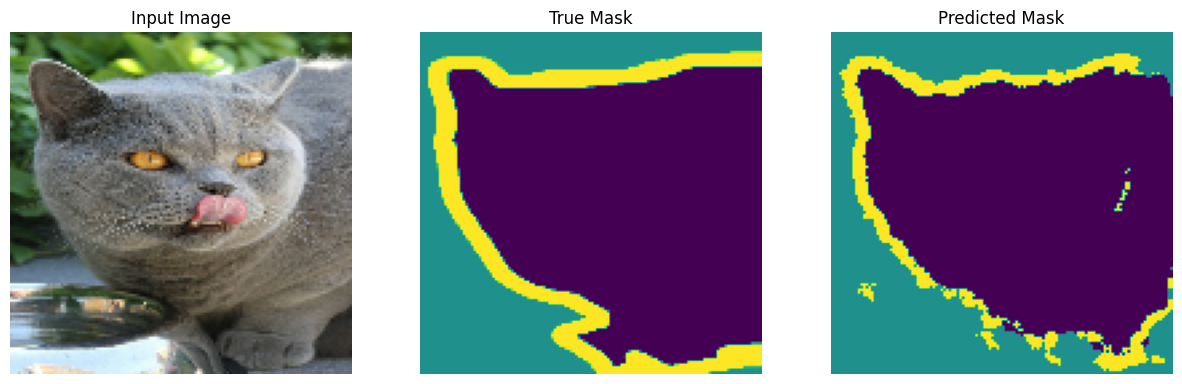

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step


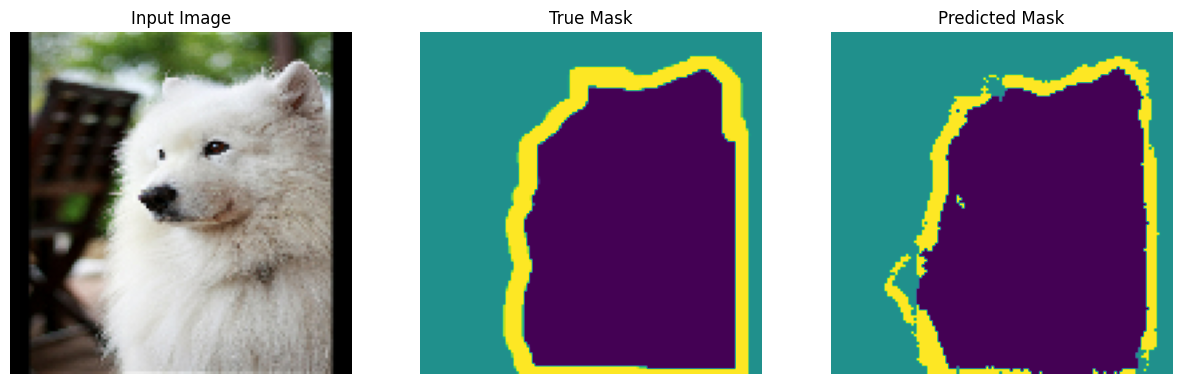

2024-07-22 00:44:42.387007: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
show_predictions(test_dataset, 3)
